# Project #2

In [8]:
import sys
!{sys.executable} -m pip install yfinance

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime 
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, silhouette_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor


from IPython.display import display, HTML, display_html
import warnings
warnings.filterwarnings('ignore')


# 1. Data Importing
## 1.1 Import 11 Select Spdrs (e.g. XLF, XLE, etc.).Some of this period did not include the Real Estate sector fund.  

We will use 'XLB' SPDR Index for our research in this work.
The Materials Select Sector Index (aka XLB) seeks to provide an effective representation of the materials sector of the S&P 500 Index. The Index includes companies from the following industries: chemicals; metals and mining; paper and forest products; containers and packaging; and construction materials.

## 1.2 Import your equity ETF prices for 2014 - 2019.

using XLC (Communications Sector) as 11th SPDR in addition to https://www.sectorspdr.com/sectorspdr/


Index name  | Short |
---------------------------------------|---|
Communication Services| XLC |
Consumer Discretionary |  XLY |
Consumer Staples  | XLP |
Energy  | XLE |
Financials  | XLF |
Health Care | XLV |
Industrials  | XLI |
Materials  | XLB |
Real Estate  | XLRE |
Technology  |  XLK |
Utilities  | XLU |
First Trust US Equity Opportunities ETF as US equity ETF | FPX |


 

In [10]:
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2019, 1, 1)

symbols = ['XLB', 'XLC', 'XLI', 'XLE', 'XLY', 'XLP', 
           'XLV', 'XLF', 'XLK', 'XLU', 'XLRE', 'FPX']

data = pd.DataFrame()

for sym in symbols: 
  try: 
    fund = []
    fund = yf.download(sym, start = start_date, end = end_date, progress = True)
    if (len(fund) == 0):
        None
    else:
        fund['Name'] = sym
        data = data.append(fund, sort = False)
  except Exception:
    None


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Let's adjust downloaded data by removing unused columns and filling the gaps in dates by backfill and linear interpolation

In [11]:
df = data[['Adj Close', 'Name']].pivot(columns='Name') 
df.columns = df.columns.droplevel(0)
spdr_etfs = df.interpolate(method='linear') \
       .fillna(method='backfill') \
       .fillna(method='ffill')
spdr_etfs

Name,FPX,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,,
2014-01-02,42.868885,39.801613,48.816391,66.751213,15.416534,44.748779,31.702387,35.207253,25.066113,29.480881,49.134388,60.454964
2014-01-03,42.811737,39.706131,48.816391,66.506401,15.522905,44.870358,31.550104,35.140892,25.066113,29.386269,49.250248,60.291382
2014-01-06,42.811737,39.489105,48.816391,66.598221,15.537092,44.609833,31.496344,35.008198,25.066113,29.433573,49.045250,59.918755
2014-01-07,42.964092,39.419666,48.816391,67.103149,15.544182,44.887714,31.783010,35.198952,25.066113,29.693773,49.562172,60.282303
2014-01-08,42.992668,39.654037,48.816391,66.636452,15.593819,44.809570,31.783010,34.933544,25.066113,29.536076,49.998878,60.118694
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,57.179127,45.365391,38.305344,47.292942,21.307533,57.944889,56.162556,46.128651,27.930761,48.263119,77.544090,89.744972
2018-12-26,60.194794,47.396961,40.457993,50.235577,22.272152,60.643345,59.554527,47.416050,28.820873,48.918350,80.926445,95.062531
2018-12-27,60.837479,48.269001,40.644753,50.499096,22.539570,61.401993,59.983398,47.870430,28.886457,49.330219,81.820061,95.569893


## 1.3 Import the data series corresponding to the Leading Economic Indicators (LEI), Coincidental Economic Indicators (CEI), and Lagging Economic Indicators (LAG)

Here we use economical indicators published
https://raw.githubusercontent.com/su23/wqu/master/640/GW2/

In [12]:
indicators_repo_url = "https://raw.githubusercontent.com/su23/wqu/master/640/GW2/"

# Leading Economic Indicators
LEI = ['SP500', 'AWHMAN','ICSA', 'ACDGNO', 'NEWORDER', 'PERMIT', 'M2', 'T10YFF']

# Lagging Economic Indicators
LAG = ['PAYEMS', 'W875RX1', 'INDPRO', 'CMRMTSPL']

# Coincidental Economic Indicators
# Fredgraph = TOTALSL_DSPI
CEI =['Fredgraph', 'BUSLOANS', 'DPRIME', 'MNFCTRIRSA', 'UEMPMEAN']

ALL = LEI + LAG + CEI

# merge with dates as defined for XLB
indicators_data = pd.DataFrame()
for indicator in ALL:
  indicator_file = indicators_repo_url + indicator + ".csv"
  
  indicator_data = pd.read_csv(indicator_file, 
                               dtype={ indicator: np.float64}, 
                               na_values=['.', ''])
  indicator_data.rename(columns={ indicator_data.columns[1]: indicator, 
                                 'DATE': 'Date' },
                        inplace = True)
  indicator_data['Date'] = pd.to_datetime(indicator_data['Date'])
  

  # ICSA index is publishe on Saturdays, let's shift it on previous Friday
  if indicator == "ICSA":
    indicator_data['Date'] = indicator_data['Date'] + datetime.timedelta(days=-1)

  # set date as index and merge indicators
  indicator_data.set_index('Date')
  if indicators_data.empty:
    indicators_data = indicator_data
  else:
    indicators_data = indicators_data.merge(indicator_data, on='Date', how='left')


Let's fill the gaps in data by linear interpolation, as long indicators are not published at the same date.

In [13]:
indicators_data = indicators_data.interpolate(method='linear') \
                      .fillna(method='backfill') \
                      .fillna(method='ffill')
indicators_data.set_index('Date')

,SP500,AWHMAN,ICSA,ACDGNO,NEWORDER,PERMIT,M2,T10YFF,PAYEMS,W875RX1,INDPRO,CMRMTSPL,Fredgraph,BUSLOANS,DPRIME,MNFCTRIRSA,UEMPMEAN
Date,,,,,,,,,,,,,,,,,
2014-01-02,1831.98,41.900000,322000.0,34980.000000,66364.000000,1090.000000,11048.70,2.53,138293.000000,11983.300000,104.637100,1.352609e+06,0.242630,1650.979800,3.25,1.300000,34.900000
2014-01-03,1831.37,41.900000,322000.0,34980.000000,66364.000000,1090.000000,11048.70,2.53,138293.000000,11983.300000,104.637100,1.352609e+06,0.242630,1650.979800,3.25,1.300000,34.900000
2014-01-06,1826.77,41.900000,321200.0,34980.000000,66364.000000,1090.000000,11048.70,2.53,138293.000000,11983.300000,104.637100,1.352609e+06,0.242630,1650.979800,3.25,1.300000,34.900000
2014-01-07,1837.88,41.900000,320400.0,34980.000000,66364.000000,1090.000000,11048.44,2.53,138293.000000,11983.300000,104.637100,1.352609e+06,0.242630,1650.979800,3.25,1.300000,34.900000
2014-01-08,1837.49,41.900000,319600.0,34980.000000,66364.000000,1090.000000,11048.18,2.53,138293.000000,11983.300000,104.637100,1.352609e+06,0.242630,1650.979800,3.25,1.300000,34.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-26,2467.70,41.909302,224400.0,43746.139535,66256.976744,1316.279070,14408.56,0.41,150100.627907,13975.820930,110.154612,1.507693e+06,0.248594,2320.344909,5.50,1.359070,20.965116
2018-12-27,2488.83,41.906977,226200.0,43759.604651,66306.232558,1316.209302,14414.54,0.37,150111.720930,13978.890698,110.145584,1.508063e+06,0.248579,2321.601907,5.50,1.359302,20.948837
2018-12-28,2485.74,41.904651,228000.0,43773.069767,66355.488372,1316.139535,14420.52,0.32,150122.813953,13981.960465,110.136556,1.508432e+06,0.248565,2322.858905,5.50,1.359535,20.932558


# 2.1 Compute the daily returns of your Equity ETF and SPDRs

Here we also adjust daily returns for gaps in SPDR indexes

In [14]:
spdr_etfs_returns = spdr_etfs.pct_change().dropna()
spdr_etfs_returns


Name,FPX,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,,
2014-01-03,-0.001333,-0.002399,0.000000,-0.003668,0.006900,0.002717,-0.004804,-0.001885,0.000000,-0.003209,0.002358,-0.002706
2014-01-06,0.000000,-0.005466,0.000000,0.001381,0.000914,-0.005806,-0.001704,-0.003776,0.000000,0.001610,-0.004162,-0.006180
2014-01-07,0.003559,-0.001758,0.000000,0.007582,0.000456,0.006229,0.009102,0.005449,0.000000,0.008840,0.010540,0.006067
2014-01-08,0.000665,0.005946,0.000000,-0.006955,0.003193,-0.001741,0.000000,-0.007540,0.000000,-0.005311,0.008811,-0.002714
2014-01-09,0.001107,-0.003940,0.000000,-0.003100,0.003638,0.004845,-0.006482,0.005223,0.000000,0.005873,0.007487,-0.000151
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,-0.019997,-0.025926,-0.021100,-0.040456,-0.021062,-0.030683,-0.026689,-0.028896,-0.036833,-0.041814,-0.023948,-0.018985
2018-12-26,0.052741,0.044782,0.056197,0.062221,0.045271,0.046569,0.060396,0.027909,0.031869,0.013576,0.043618,0.059252
2018-12-27,0.010677,0.018399,0.004616,0.005246,0.012007,0.012510,0.007201,0.009583,0.002276,0.008420,0.011042,0.005337


# 3. Category 1 Models: Linear Regression
## 3.1	For each ETF (there's 11 in total!), run a regression modeling the ETF returns on the 10 Leading EI (LEI) factors.  This will give a total of 11 regression models.  Be sure to use the weights located in the link above.

Before building linear regression model let's adjust dates so SPRD ETF indexes would have correspond LEI index values for that date

In [15]:
all_indexes = pd.merge(spdr_etfs, indicators_data, how='inner', on=['Date'])
all_indexes.set_index('Date')
None

Run Linear regression model for each SPDR ETF Index using LEI indexes as models

In [16]:
def calc_linear_regression(X, Y, name):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
  reg = LinearRegression()
  reg.fit(X_train, y_train)
  # calc mse
  _mse = mean_squared_error(reg.predict(X_test), y_test)

  # add MSE to data frame
  _df_data = np.hstack((reg.coef_, _mse))
  _df_index = list(X.columns.to_list())
  _df_index.append('MSE')
  
  return pd.DataFrame(data=_df_data, columns={name}, index=_df_index)


In [17]:
# calculate linear coef for ETFS
def calc_linear_coeff_etfs(underlyings) :
  _df_all = pd.DataFrame()
  for spdr_etf in spdr_etfs.columns:
    # calc linear coefs
    _df = calc_linear_regression(underlyings, all_indexes[spdr_etf], spdr_etf)
    _df_all = _df if _df_all.empty else _df_all.merge(_df, left_index=True, right_index=True)
  
  return _df_all

LEI_df = all_indexes[LEI]
lei_coeffs = calc_linear_coeff_etfs(LEI_df)
lei_coeffs

,FPX,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
SP500,0.028057,0.026395,0.000000,0.019348,0.010481,0.026625,0.018236,0.014301,2.979768e-03,0.011540,0.039395,0.029966
AWHMAN,-7.882758,6.108400,0.000000,29.530131,-0.746245,4.042910,1.566726,-1.389903,1.644996e+00,3.784708,-13.190915,-14.248672
ICSA,-0.000006,0.000034,0.000000,0.000104,-0.000009,0.000027,-0.000006,0.000002,2.573759e-05,0.000008,-0.000050,-0.000003
ACDGNO,0.000288,-0.000334,0.000000,-0.000196,-0.000197,-0.000674,-0.000225,0.000309,-8.612352e-05,-0.000196,0.001265,0.000168
NEWORDER,0.000139,0.000090,0.000000,0.000713,0.000071,-0.000054,0.000224,-0.000345,2.804883e-08,-0.000122,-0.000229,-0.000181
PERMIT,0.007930,0.006426,0.000000,0.017772,-0.001001,-0.001192,0.003800,-0.007783,1.020739e-03,-0.009410,0.001128,-0.003152
M2,-0.002003,-0.000736,0.000000,-0.001034,0.001693,0.003753,0.004340,0.000672,1.075806e-03,0.002367,-0.008262,0.003421
T10YFF,-0.226860,0.137548,0.000000,5.609230,2.116252,1.337789,0.104068,-3.356044,-1.406705e+00,-4.433716,-5.359757,0.360063
MSE,9.890881,10.904501,4.978996,61.449070,0.626829,1.764602,26.082218,25.405244,9.768007e-01,15.317031,5.658613,68.763002


## 3.2	Repeat the regression modeling, but this time use the 7 Lagging EI factors (LAG).  This will give another 11 regression models.


In [18]:
LAG_df = all_indexes[LAG]

lag_coeffs = calc_linear_coeff_etfs(LAG_df)
lag_coeffs

,FPX,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
PAYEMS,0.000827,0.003710,0.000000,0.006932,0.000966,0.004424,0.004032,0.002118,0.002199,0.003508,-0.001421,0.002273
W875RX1,0.010086,-0.013175,0.000000,-0.056341,-0.001707,-0.015153,-0.004691,0.002451,-0.007347,-0.008590,0.033731,0.013177
INDPRO,1.150298,2.459003,0.000000,4.601121,0.994231,2.607201,1.980574,0.270699,0.459773,1.086208,0.155881,0.687838
CMRMTSPL,-0.000059,-0.000038,0.000000,0.000074,0.000026,0.000029,-0.000069,-0.000071,-0.000063,-0.000036,-0.000141,-0.000102
MSE,22.929112,55.893333,4.978996,102.712236,13.311474,68.791361,20.192339,21.000559,2.499493,29.202624,20.021707,74.911343


## 3.3. Repeat the regression modeling, but this time use the 4 Coincidental EI factors (CEI).  This will give another 11 regression models


In [19]:
CEI_df = all_indexes[CEI]

cei_coeffs = calc_linear_coeff_etfs(CEI_df)
cei_coeffs

,FPX,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Fredgraph,741.899284,422.687879,0.000000,-248.617563,160.756996,554.397137,199.313779,192.662499,130.226308,426.970004,878.332797,379.506861
BUSLOANS,-0.024250,0.001671,0.000000,0.025473,-0.006822,0.005330,0.000688,0.017705,0.009370,0.021511,-0.029961,-0.006397
DPRIME,7.895049,6.216644,0.000000,-12.882264,4.926733,13.181969,12.306128,6.176135,1.879967,9.220362,9.103990,13.562915
MNFCTRIRSA,27.473504,-41.184612,0.000000,-225.408773,-5.787304,-24.820222,-5.331603,18.248040,-10.394938,6.352555,97.533615,40.028583
UEMPMEAN,-0.874348,-0.068898,0.000000,-0.387769,-0.462410,-0.029089,-0.714836,0.210188,0.259482,0.772755,-0.785597,-1.173211
MSE,74.912411,17.450621,4.978996,28.573944,4.550648,34.962386,26.788579,31.292896,1.100933,25.366961,106.912462,62.764463


## 3.4	Repeat the regression one more time, using all 21 EI factors: LEI, LAG, and CEI.  This will give another 11 regression models.

In [20]:
ALL_df = all_indexes[ALL]

all_coeffs = calc_linear_coeff_etfs(ALL_df)
all_coeffs

,FPX,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
SP500,0.026725,0.028873,0.000000,0.037224,0.008632,0.028076,0.018241,0.015238,0.007110,0.011822,0.030437,0.033276
AWHMAN,-4.128920,4.919163,0.000000,26.714402,-1.770379,2.300556,2.088983,-0.533942,-2.739594,1.174688,-12.936174,-5.030437
ICSA,0.000013,0.000002,0.000000,-0.000014,-0.000003,0.000001,-0.000002,0.000003,0.000004,-0.000014,-0.000002,0.000032
ACDGNO,0.000011,-0.000137,0.000000,0.000450,-0.000180,-0.000166,-0.000205,0.000351,-0.000118,0.000027,0.000573,0.000005
NEWORDER,-0.000195,-0.000031,0.000000,0.000705,-0.000055,-0.000294,-0.000057,0.000003,0.000151,0.000028,0.000111,-0.000058
PERMIT,0.006696,0.004495,0.000000,0.007643,0.000150,-0.002992,0.003089,-0.009593,-0.002122,-0.010531,0.008290,-0.008160
M2,-0.001489,0.006443,0.000000,0.021015,-0.001437,0.002647,0.002219,0.000491,-0.002030,0.006275,-0.005208,-0.007052
T10YFF,-0.121578,-0.413427,0.000000,1.273105,2.157017,0.581246,-0.599780,-2.701722,-1.671099,-3.687669,-2.399371,0.296248
PAYEMS,-0.000296,-0.005651,0.000000,-0.013758,0.000776,-0.001075,0.001352,0.001025,0.004198,-0.000477,0.002165,0.003846
W875RX1,-0.002233,0.013953,0.000000,0.027008,-0.001010,0.007068,0.001024,0.000833,-0.019684,-0.004150,-0.021581,0.007499


## 3.5 By now, you will have 3 models for XLRE: 1 using LEI, 1 using LAG, 1 using CEI, and 1 using ALL economic indicators.  Similarly, there will be 4 models for each of the other sector ETFs.

Let's try to bring togather all models and coefficents for XRLE

In [21]:
_xlre_all = all_coeffs[['XLRE']].rename(columns={'XLRE': 'ALL'})
_xlre_cei = cei_coeffs[['XLRE']].rename(columns={'XLRE': 'Only CEI'})
_xlre_lei = lei_coeffs[['XLRE']].rename(columns={'XLRE': 'Only LEI'})
_xlre_lag = lag_coeffs[['XLRE']].rename(columns={'XLRE': 'Only LAG'})

_xlre = _xlre_all.merge( _xlre_cei, left_index=True, right_index=True, how='left' ) \
                 .merge( _xlre_lei, left_index=True, right_index=True, how='left' ) \
                 .merge( _xlre_lag, left_index=True, right_index=True, how='left' ) 

_xlre = _xlre.replace(np.nan, '', regex=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
_xlre

,ALL,Only CEI,Only LEI,Only LAG
SP500,0.00711,,0.00298,
AWHMAN,-2.73959,,1.64500,
ICSA,0.00000,,0.00003,
ACDGNO,-0.00012,,-0.00009,
NEWORDER,0.00015,,0.00000,
PERMIT,-0.00212,,0.00102,
M2,-0.00203,,0.00108,
T10YFF,-1.67110,,-1.40671,
PAYEMS,0.00420,,,0.00220
W875RX1,-0.01968,,,-0.00735


## 3.6 Use the model selection paper [Reference Above].  For each sector ETF, compare the results 3.4 with the results from questions 3.1, 3.2, and 3.3

According to the paper https://conference-board.org/pdf_free/press/US%20LEI%20-%20Tech%20Notes%20JANUARY%202021.pdf following coeffiencts are expected

**Leading Economic Index**

Index name  | coefficients |
---|---|
Average weekly hours, manufacturing | 0.2798|
Average weekly initial claims for unemployment insurance | 0.0326|
Manufacturers' new orders, consumer goods and materials | 0.0844|
ISM® new orders index | 0.1587 |
Manufacturers' new orders, nondefense capital goods excl.
aircraft | 0.0411 |
Building permits, new private housing units | 0.0289 |
Stock prices, 500 common stocks | 0.0393 | 
Leading Credit Index | 0.0833 |
Interest rate spread, 10-year Treasury bonds less federal funds | 0.1109 |
Avg. consumer expectations for business conditions | 0.1410 |
<br/>

**Coincident Economic Index**

Index name  | coefficients |
---------------------------------------|---|
Employees on nonagricultural payrolls  | 0.5302 |
Personal income less transfer payments | 0.2052 |
Industrial production |  0.1446 |
Manufacturing and trade sales| 0.1200 |

**Lagging Economic Index**

Index name  | coefficients |
---------------------------------------|---|
Inventories to sales ratio, manufacturing and trade | 0.1282 |
Average duration of unemployment  |  0.0356|
Consumer installment credit outstanding to personal income ratio  | 0.1842 |
Commercial and industrial loans  | 0.0844 |
Average prime rate  | 0.3055 |
Labor cost per unit of output, manufacturing  | 0.0508 |
Consumer price index for services  | 0.2113 |
 
    

Even thought XLRE shows the smallest mean square error among other models (1.382394) for linear regression model based on all indicators, we could not match the coefficients in the paper.

There could be multiple reasons:

*  Quality of the data downloaded from open sources
*  Linera interpolaion for missing data
*  Different time ranges taken for analysis

Please find below calculated coefficients

In [33]:
display(all_coeffs['XLRE'])

SP500         0.00711
AWHMAN       -2.73959
ICSA          0.00000
ACDGNO       -0.00012
NEWORDER      0.00015
PERMIT       -0.00212
M2           -0.00203
T10YFF       -1.67110
PAYEMS        0.00420
W875RX1      -0.01968
INDPRO        0.58484
CMRMTSPL     -0.00004
Fredgraph    96.15750
BUSLOANS     -0.01453
DPRIME        1.10404
MNFCTRIRSA   32.68538
UEMPMEAN     -0.05991
MSE           1.38239
Name: XLRE, dtype: float64

# 4. Model Selection

## 4.1 For each ETF, which of the sets: LEI, LAG, or CEI, was the best model?

In [34]:
all_coeffs_mse = all_coeffs.loc['MSE']
cei_coeffs_mse = cei_coeffs.loc['MSE']
lei_coeffs_mse = lei_coeffs.loc['MSE']
lag_coeffs_mse = lag_coeffs.loc['MSE']

all_coeffs_min_idx = all_coeffs_mse.idxmin()
cei_coeffs_min_idx = cei_coeffs_mse.idxmin()
lei_coeffs_min_idx = lei_coeffs_mse.idxmin()
lag_coeffs_min_idx = lag_coeffs_mse.idxmin()

print('LinearRegression best fit when using factors : ');
print('All factors : %s with mse=%.5f' % \
      (all_coeffs_min_idx, all_coeffs_mse[all_coeffs_min_idx] ))
print('CEI factors : %s with mse=%.5f' % \
      (cei_coeffs_min_idx, cei_coeffs_mse[cei_coeffs_min_idx] ))
print('LEI factors : %s with mse=%.5f' % \
      (lei_coeffs_min_idx, cei_coeffs_mse[lei_coeffs_min_idx] ))
print('LAG factors : %s with mse=%.5f' % \
      (lag_coeffs_min_idx, lag_coeffs_mse[lag_coeffs_min_idx] ))



LinearRegression best fit when using factors : 
All factors : XLRE with mse=1.38239
CEI factors : XLRE with mse=1.10093
LEI factors : XLF with mse=4.55065
LAG factors : XLRE with mse=2.49949


*XLRE (Real Estate Select Sector SPDR Fund) definitely shows the best fit using different factors. The best fit for XRLE is provided by linear models of  Coincident Economic Indexes*



# 5. Category 2 Models: LASSO

## 5.1 For each sector ETF, run a LASSO regression with all 21 economic indicators.  


Let's build lass function to calculate lasso coefficients and $R^2$

In [35]:
def calc_lasso(X, Y, name):
  lasso = Lasso(alpha=0.000015)
  lasso.fit(X, Y)
  Y_lasso_predicted = lasso.predict(X)

  # calc r2
  a_score = r2_score(Y, Y_lasso_predicted)*100

  # add MSE to data frame
  _df_data = np.hstack((lasso.coef_, a_score))
  _df_index = list(X.columns.to_list())
  _df_index.append('R2')
  
  return pd.DataFrame(data=_df_data, columns={name}, index=_df_index)


Now, calculate all Lasso for all SPDR ETFS using all economic factors

In [36]:
def calc_lasso_coeff_etfs(underlyings) :
  _df_all = pd.DataFrame()
  for spdr_etf in spdr_etfs.columns:
    # calc linear coefs
    _df = calc_lasso(underlyings, all_indexes[spdr_etf], spdr_etf)
    _df_all = _df if _df_all.empty else _df_all.merge(_df, left_index=True, right_index=True)
  
  return _df_all

X_lasso = ALL_df
lasso_coeff_df = calc_lasso_coeff_etfs(X_lasso)
lasso_coeff_df

,FPX,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
SP500,0.03001,0.02409,0.00514,0.03343,0.00887,0.02887,0.02429,0.01148,0.00513,0.00386,0.02963,0.04170
AWHMAN,-1.23891,2.54050,1.06168,9.18546,0.14094,2.64485,0.07771,-1.90966,-2.93866,-2.73849,-2.71699,-4.74882
ICSA,0.00002,0.00001,-0.00000,-0.00001,-0.00000,-0.00000,-0.00000,-0.00000,0.00001,-0.00002,0.00002,0.00000
ACDGNO,0.00004,-0.00027,-0.00007,-0.00062,-0.00013,-0.00030,-0.00006,0.00048,0.00004,-0.00009,0.00087,-0.00004
NEWORDER,0.00010,-0.00014,-0.00006,0.00019,-0.00016,-0.00040,0.00026,-0.00039,0.00017,0.00004,0.00047,-0.00001
PERMIT,0.00648,0.00758,-0.00496,0.00533,0.00021,-0.00016,0.00081,-0.00522,-0.00178,-0.00802,0.00658,-0.00708
M2,-0.00937,0.00149,-0.00187,0.00410,0.00012,0.00315,-0.00045,0.00801,0.00207,0.01096,-0.00533,-0.01042
T10YFF,-0.96079,-1.70183,-0.62591,0.86543,1.81054,0.85749,-0.19974,-2.39620,-1.92328,-4.00826,-2.41471,1.65494
PAYEMS,0.00158,-0.00217,0.00075,-0.00712,0.00041,-0.00050,0.00195,-0.00087,0.00085,-0.00121,0.00014,0.00357
W875RX1,0.00497,0.01039,0.00414,-0.00737,0.00270,0.00014,-0.00304,-0.00327,-0.00802,-0.00232,0.00206,-0.00732


## 5.2	Compare and contrast (with technical details) the results from 5.1 with the results from 3.6.  Did you come up with same conclusion?


In [37]:
lasso_r2 = lasso_coeff_df.loc['R2']
lasso_r2_idx = lasso_r2.idxmax()
print("The best lasso fit is for %s with R^2=%.5f" % \
       ( lasso_r2_idx, lasso_r2[lasso_r2_idx]))

The best lasso fit is for XLK with R^2=99.54792


Suprisingly LASSO provides excellent fit where over than 90% of variance is explained by the models, except XLC (Communication Services Select Sector SPD) which has only 78.183;

Comparing the results with Seciton 3.6 we can definitely see that for both linear regression and Lasso the highest influence to the model comes from:
 
*  (Fredgraph)  Disposable Personal Income 
*  (MNFCTRIRSA) Manufacturers: Inventories to Sales Ratio

While three other factors show almost zero coefficients in all models:

* (ACDGNO) Manufacturers' New Orders: Consumer Durable Goods
* (ICSA) - Inventories to sales ratio, manufacturing and trade
* (CMRMTSPL) - Real Manufacturing and Trade Industries Sales



# 6. Category 3 Models: Cluster Analysis

## 6.1 Using daily returns, compute a distance matrix from the correlation or covariance matrix.  Run a cluster analysis using k=3.

First, lets try to bring together all returns onto one plane to visually estimate clustering on SPDR ETF returns

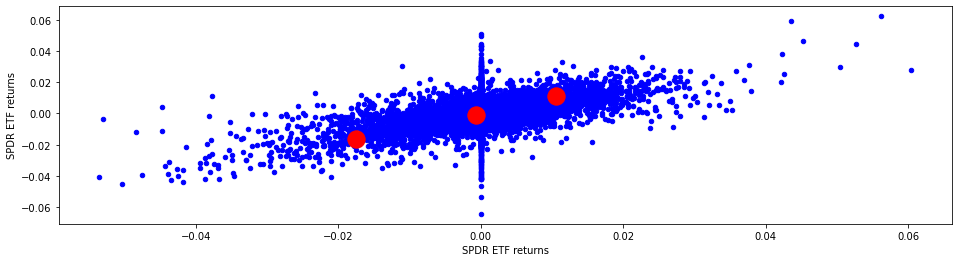

In [39]:
N_CLUSTERS = 3
X = spdr_etfs_returns

kmeans = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=42)
kmeans.fit(X)
pred_y = kmeans.fit_predict(X)
score = silhouette_score(spdr_etfs_returns, kmeans.labels_)

# scatter plot all returns
fig, ax1 = plt.subplots(1,1, figsize=(16,4))
for x1,x2 in zip(['FPX','XLC','XLF','XLK','XLRE', 'XLV'],
                 ['XLB','XLE','XLI','XLP', 'XLU', 'XLY']):
  X.plot(kind='scatter', x=x1, y=x2, color='b', ax=ax1)    

ax1.set_xlabel("SPDR ETF returns")
ax1.set_ylabel("SPDR ETF returns")

# add cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 1], 
            s = 300,
            c='red')
plt.show()

No we build covariance matrix for returns for SPDR ETFS

In [43]:
spdr_etfs_cov = X.cov()
spdr_etfs_cov

Name,FPX,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Name,,,,,,,,,,,,
FPX,0.00010,0.00008,0.00002,0.00008,0.00008,0.00008,0.00009,0.00004,0.00003,0.00002,0.00008,0.00008
XLB,0.00008,0.00011,0.00001,0.00010,0.00008,0.00008,0.00008,0.00004,0.00003,0.00002,0.00006,0.00007
XLC,0.00002,0.00001,0.00002,0.00001,0.00001,0.00001,0.00002,0.00001,0.00001,0.00000,0.00001,0.00002
XLE,0.00008,0.00010,0.00001,0.00018,0.00008,0.00008,0.00007,0.00004,0.00002,0.00003,0.00006,0.00007
XLF,0.00008,0.00008,0.00001,0.00008,0.00011,0.00008,0.00008,0.00004,0.00002,0.00002,0.00007,0.00007
XLI,0.00008,0.00008,0.00001,0.00008,0.00008,0.00009,0.00008,0.00004,0.00002,0.00002,0.00006,0.00007
XLK,0.00009,0.00008,0.00002,0.00007,0.00008,0.00008,0.00011,0.00005,0.00003,0.00003,0.00007,0.00008
XLP,0.00004,0.00004,0.00001,0.00004,0.00004,0.00004,0.00005,0.00005,0.00003,0.00004,0.00004,0.00004
XLRE,0.00003,0.00003,0.00001,0.00002,0.00002,0.00002,0.00003,0.00003,0.00006,0.00003,0.00002,0.00003


Then we calculate distances for returns based on covariance matrix

In [44]:
from scipy.spatial.distance import squareform, pdist
X = spdr_etfs_cov
distance_cov_matrix = pd.DataFrame(squareform(pdist(X)), columns=X.columns, index=X.columns)
distance_cov_matrix

Name,FPX,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Name,,,,,,,,,,,,
FPX,0.00000,0.00005,0.00020,0.00010,0.00004,0.00003,0.00002,0.00012,0.00017,0.00018,0.00005,0.00003
XLB,0.00005,0.00000,0.00020,0.00008,0.00004,0.00003,0.00005,0.00012,0.00017,0.00018,0.00007,0.00005
XLC,0.00020,0.00020,0.00000,0.00024,0.00020,0.00018,0.00020,0.00010,0.00007,0.00010,0.00017,0.00018
XLE,0.00010,0.00008,0.00024,0.00000,0.00010,0.00010,0.00011,0.00017,0.00021,0.00022,0.00012,0.00011
XLF,0.00004,0.00004,0.00020,0.00010,0.00000,0.00003,0.00005,0.00012,0.00017,0.00018,0.00006,0.00004
XLI,0.00003,0.00003,0.00018,0.00010,0.00003,0.00000,0.00004,0.00010,0.00015,0.00017,0.00005,0.00003
XLK,0.00002,0.00005,0.00020,0.00011,0.00005,0.00004,0.00000,0.00012,0.00017,0.00018,0.00005,0.00003
XLP,0.00012,0.00012,0.00010,0.00017,0.00012,0.00010,0.00012,0.00000,0.00007,0.00007,0.00008,0.00009
XLRE,0.00017,0.00017,0.00007,0.00021,0.00017,0.00015,0.00017,0.00007,0.00000,0.00006,0.00014,0.00015


And finally perform clustering analysis based on dendrogram which plots out each cluster and the distances

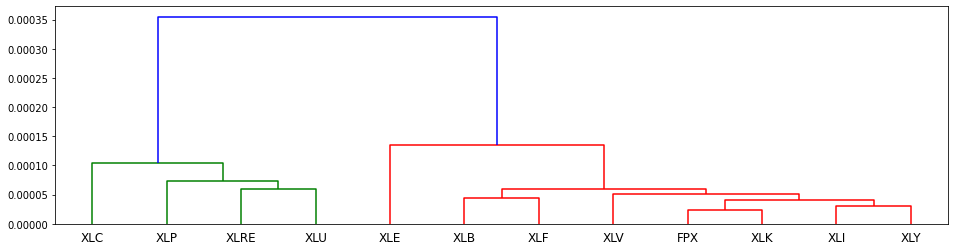

In [45]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

fig, ax1 = plt.subplots(1,1, figsize=(16,4))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'), ax=ax1, labels=X.columns)
hc = AgglomerativeClustering(n_clusters=N_CLUSTERS, affinity = 'euclidean', linkage = 'ward')


## 6.2 Compare and contrast (with technical details) the results from 6.1 with the results from 3.6 and 5.1.  Did you come up with same conclusion?


In the dendrogram above we have identified three clusters for ETF returns, shown with red/green/blue colors accrodingly.

It can be obvoisly seen from dendrogram that XLB (Materials Select Sector SPDR Fund), XLF(Financial Select Sector SPDR Fund), XLV(Health Care Select Sector SPDR Fund), FPX, XLK (Technology Select Sector SPDR Fund), XLI (Industrial Select Sector SPDR Fund), XLY (Consumer Discretionary Select Sector SPDR Fund)  create a supercluster which can be interpreted as having strong dependency on same economical factors.  

While XLC (Communication Services), XLP (Consumer Staples), XLRE (Real Estate), XLU (Utilities) builds a second cluster. These four indexes mainly represent consumers reactions on overal economical state.

XLE (Energy Select Sector SPDR Fund) keeps apart from other two clusters. We might assume that energy sector has the highest influence of geopolitcs rather than other economical factors.



#7. Category 4 Models: Tree

## 7.1 For each ETF, run a regression tree using all 21 economic indicators.

In [46]:
def calc_regression_tree(X, Y, name):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1/3, shuffle=False)
  
  regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                               max_samples=1.0,
                               bootstrap=True,
                               random_state=0) \
                  .fit(X_train, y_train)
  score = regressor.score(X_test, y_test)
  return score

def calc_regression_tree_etfs(underlyings) :
  _all_scores = []
  for spdr_etf in spdr_etfs.columns:
    # run regression tree for each ETF returns? or for ETFs?
    score = calc_regression_tree(underlyings, spdr_etfs[spdr_etf], spdr_etf)
    #score = calc_regression_tree(underlyings, spdr_etfs_returns[spdr_etf], spdr_etf)
    _all_scores.append(score)

  return pd.DataFrame(data  = _all_scores, 
                      columns={'Score'},
                      index = spdr_etfs.columns.to_list() )

tree_coeff_df = calc_regression_tree_etfs(ALL_df)
tree_coeff_df

,Score
FPX,-3.04526
XLB,-3.40985
XLC,-0.17434
XLE,-0.18504
XLF,-2.68380
XLI,-2.91524
XLK,-3.61562
XLP,-0.06446
XLRE,-0.15982
XLU,-2.12424


## 7.2 Compare and contrast (with technical details) the results from 7.1 with the results from 3.4, 5.1, and 6.1.  Did you come up with same conclusion?

Suprisingly, all regression tree models got negative score values, which means none of them can be used to make a prediction.  

Clustering analysis from section 6 helped to identify how SPDR ETF returns correlate to each other, and help to identify groups of ETFS with similar reactions on economical events.

Lasso and linear regression showed the weights of macro economical factors on each ETF returns.

## These questions are to be addressed in a separate PDF: 

8.1	You have now found a set of sectors that regress best on Leading Indicators.  What do these sectors have in common?<br />
8.2	Similarly, you have found a set of sectors that regress best on Coincidental indicators.  What do these sectors have in common? <br/>
8.3 Similarly, you have found a set of sectors that regress best on lagging.  What do these sectors have in common? <br/>

9.1	Write a 1-page report to the Portfolio Manager summarizing how each ETF got assigned to LEI, CEI, OR LAG.  It must be non-technical<br>
9.2	Write a 1-page report that specifically explains how your group divided the work with details.<br>

https://docs.google.com/document/d/1pL2L9x8UIV2I3XQ35h7iyu5-3OxVXDBmCX7FrPYoWUY/edit?usp=sharing